In [56]:
import os
import zipfile
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [57]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-08-19 06:57:44--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.35.76.84, 2600:1407:a800:19e::e59, 2600:1407:a800:1ac::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.35.76.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   186MB/s    in 4.2s    

2020-08-19 06:57:49 (189 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [58]:
try:
    
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [59]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if (os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file size! i.e Zero length.')
    
    train_data_length = int(len(dataset) * SPLIT_SIZE)
    test_data_length = int(len(dataset) - train_data_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = shuffled_set[0:train_data_length]
    test_set = shuffled_set[-test_data_length:]
    
    for unitData in train_set:
        temp_train_data = SOURCE + unitData
        final_train_data = TRAINING + unitData
        copyfile(temp_train_data, final_train_data)
    
    for unitData in test_set:
        temp_test_data = SOURCE + unitData
        final_test_data = TESTING + unitData
        copyfile(temp_train_data, final_test_data)



CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

Skipped 666.jpg
Invalid file size! i.e Zero length.
Skipped 11702.jpg
Invalid file size! i.e Zero length.


In [60]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('accuracy')>0.99):
      print("Reaches 99% accuracy. Cancelling training")
      self.model.stop_training = True

callbacks = myCallback()

In [61]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu', input_shape = (150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(8,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128 , activation='relu'),
    tf.keras.layers.Dense(1 , activation='sigmoid')

])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator( rescale = 1/255)


train_generator = train_datagen.flow_from_directory(
TRAINING_DIR , batch_size = 10 , class_mode = 'binary' , target_size = (150,150))

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator( rescale = 1/255)


validation_generator = validation_datagen.flow_from_directory(
VALIDATION_DIR , batch_size= 10 , class_mode = 'binary' , target_size=(150,150))


Found 24745 images belonging to 2 classes.
Found 4747 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator ,epochs=100, verbose=1, validation_data=validation_generator , callbacks=[callbacks])

Epoch 1/100
 502/2475 [=====>........................] - ETA: 1:12 - loss: 0.4287 - accuracy: 0.8193

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2475/2475 [==============================] - 106s 43ms/step - loss: 0.4371 - accuracy: 0.8165 - val_loss: 0.8495 - val_accuracy: 0.5007
Epoch 2/100
2475/2475 [==============================] - 106s 43ms/step - loss: 0.4820 - accuracy: 0.8110 - val_loss: 0.3604 - val_accuracy: 1.0000
Epoch 3/100
2475/2475 [==============================] - 106s 43ms/step - loss: 0.5071 - accuracy: 0.8093 - val_loss: 0.4869 - val_accuracy: 0.5007
Epoch 4/100
2475/2475 [==============================] - 107s 43ms/step - loss: 0.5043 - accuracy: 0.8106 - val_loss: 0.6113 - val_accuracy: 0.5007
Epoch 5/100
2475/2475 [==============================] - 107s 43ms/step - loss: 0.5306 - accuracy: 0.8098 - val_loss: 0.4069 - val_accuracy: 0.7367
Epoch 6/100
2475/2475 [==============================] - 107s 43ms/step - loss: 0.6136 - accuracy: 0.8040 - val_loss: 0.5882 - val_accuracy: 0.5007
Epoch 7/100
2475/2475 [==============================] - 107s 43ms/step - loss: 0.4978 - accuracy: 0.8002 - val_loss: 0.6231

Text(0.5, 1.0, 'Training and validation loss')

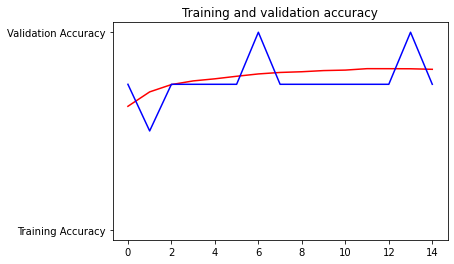

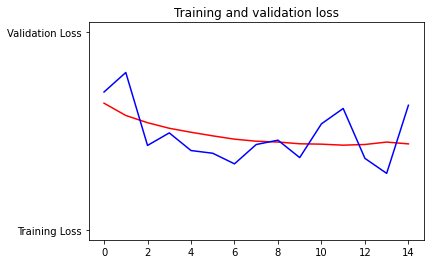

In [64]:

%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

